In [325]:
import os
import numpy as np
import tensorflow as tf
import keras.metrics
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop

In [320]:
# Adds Precision and Recall metrics
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [72]:
# Loading in data
data = np.genfromtxt('data/toy_data.csv', delimiter=',')
len(data)

3000

In [123]:
labels = data[:,0]
images = data[:, 1:].reshape((len(data),50,50,1))

No handles with labels found to put in legend.


1.0


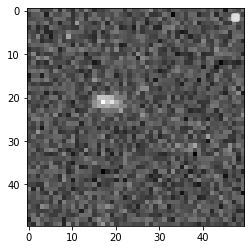

In [220]:
# Visualisation of a sample image
n = 0
print(labels[n])
plt.imshow(images[n][:,:,0], cmap='gray')
plt.legend()

In [225]:
np.unravel_index(np.argmax(images[0]), images[0].shape)

(21, 17, 0)

In [228]:
images[0, 21, 17, 0]

137.41

In [218]:
images[0][18:23, 10:20].reshape((5, 10))

array([[104.56,  97.8 ,  95.62, 103.84, 106.65,  93.05, 100.05,  98.78,
         93.48, 104.63],
       [104.82,  95.01,  99.04, 101.22,  92.83, 106.42, 101.25, 108.23,
         98.93, 103.35],
       [105.08,  99.67,  94.64,  93.31,  99.11, 108.05, 124.53, 124.14,
        123.39, 121.24],
       [ 89.33, 103.82,  97.72,  97.25, 102.76, 112.85, 117.26, 137.41,
        125.13, 131.31],
       [ 92.74,  99.53, 101.6 ,  96.56,  98.49, 112.47, 119.07, 117.47,
        119.95, 114.98]])

In [222]:
print(np.min(images))
print(np.max(images))

72.81
160.78


### Data Pre-Processing

In [333]:
# Subtract the mean, remove all negative values and scale following the max of each image
images_scaled = np.subtract(images, np.mean(images, axis=0))
images_scaled[images_scaled < 0] = 0.
images_scaled = np.divide(images_scaled, np.max(images_scaled, axis=0))

In [334]:
# One hot encode labels
x = images_scaled
y = to_categorical(labels)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

[0. 1. 0.]


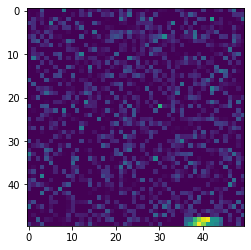

In [335]:
# Displays a sample image after pre-processing
n = 6
print(y_train[n])
plt.imshow(x_train[n][:,:,0])

### Building the Model

In [336]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 50x50 with 1 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(50, 50, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [337]:
history = model.fit(
      x_train,
      y_train,  
      epochs=10,
      verbose=1,
      #validation_data=(x_test, y_test)
)

Epoch 1/10
2400/2400 [==============================] - 7s 3ms/sample - loss: 0.9997 - acc: 0.4392
Epoch 2/10
2400/2400 [==============================] - 5s 2ms/sample - loss: 0.3525 - acc: 0.8642
Epoch 3/10
2400/2400 [==============================] - 6s 2ms/sample - loss: 0.0846 - acc: 0.9767
Epoch 4/10
2400/2400 [==============================] - 5s 2ms/sample - loss: 0.0514 - acc: 0.9871
Epoch 5/10
2400/2400 [==============================] - 6s 2ms/sample - loss: 0.0394 - acc: 0.9908
Epoch 6/10
2400/2400 [==============================] - 6s 2ms/sample - loss: 0.0335 - acc: 0.9921
Epoch 7/10
2400/2400 [==============================] - 5s 2ms/sample - loss: 0.0330 - acc: 0.9908
Epoch 8/10
2400/2400 [==============================] - 5s 2ms/sample - loss: 0.0269 - acc: 0.9942
Epoch 9/10
2400/2400 [==============================] - 6s 2ms/sample - loss: 0.0247 - acc: 0.9937
Epoch 10/10
2400/2400 [==============================] - 6s 2ms/sample - loss: 0.0192 - acc: 0.9942


In [338]:
model.evaluate(x_test, y_test)
y_pred = model.predict(x_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

600/600 [==============================] - 1s 2ms/sample - loss: 0.0240 - acc: 0.9933
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       214
           1       0.98      1.00      0.99       205
           2       1.00      0.98      0.99       181

   micro avg       0.99      0.99      0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600

